# BH Spectra

In [1]:
import veloxchem as vlx

## Systematic Search

We define a structure by using a SMILES string.

In [2]:
molecule = vlx.Molecule.read_smiles(
    "CC(C)[C@@H](C(=O)O)N"
)  # this is SMILES for alanine
molecule.show(atom_indices=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

ConformerGenerator class can generate all possible conformations and apply energy minimization process with MMforcefield

In [3]:
conf = vlx.ConformerGenerator()
conformers_dict = conf.generate(molecule)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

show the lowest energy conformer

In [4]:
conf.show_global_minimum()

Global minimum conformer with energy 155.254 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

 show more conformers

In [5]:
conf.show_conformers(number=5, atom_indices=True)

Conformer 1 with energy 155.254 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 2 with energy 159.591 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 3 with energy 166.045 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 4 with energy 167.343 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 5 with energy 167.832 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

we can provide resp charges as partial charges to improve the used MMforcefield quality

In [6]:
basis = vlx.MolecularBasis.read(molecule, "6-31g*")
resp = vlx.RespChargesDriver()
resp.ostream.mute()
partial_charges = resp.compute(molecule, basis, 'resp')

In [7]:
conf = vlx.ConformerGenerator()
conf.partial_charges = partial_charges
conformers_dict = conf.generate(molecule)
conf.show_global_minimum(atom_indices=True)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

we can apply implicit solvent model for the energy minimization 

In [8]:
conf = vlx.ConformerGenerator()
conf.ostream.mute()
conf.show_available_implicit_solvent_models()

conf.implicit_solvent_model = "obc2"
conformers_dict = conf.generate(molecule)
conf.show_global_minimum(atom_indices=True)

Available implicit solvent files:
gbn.xml
hct.xml
obc1.xml
gbn2.xml
obc2.xml
                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10       

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

show more conformers

In [9]:
conf.show_conformers(number=3, atom_indices=True)

Conformer 1 with energy 91.304 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 2 with energy 94.390 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Conformer 3 with energy 101.046 kJ/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
conformers_qm_optimized = []
conformers_qm_energies = []
for conformer in conformers_dict['molecules'][:3]:
    basis = vlx.MolecularBasis.read(conformer, 'sto-3g')
    scf_drv = vlx.ScfRestrictedDriver()
    scf_drv.xcfun = 'hf'
    results = scf_drv.compute(conformer, basis)
    opt_drv = vlx.OptimizationDriver(scf_drv)
    opt_results = opt_drv.compute(conformer, basis, results)
    conformers_qm_optimized.append(vlx.Molecule.read_xyz_string(opt_results['final_geometry']))
    conformers_qm_energies.append(opt_results['opt_energies'][-1])  


                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [11]:
import numpy as np

print(conformers_qm_energies)
# print the difference between the energies of the conformers in kJ/mol with respect to the lowest energy conformer
lowest_energy = np.min(conformers_qm_energies)
print(lowest_energy)
relative_energies_kJ = [(energy - lowest_energy) * 2625.5 for energy in conformers_qm_energies]
print(relative_energies_kJ) 

# calculate the boltzmann distribution of the conformers
def boltzmann_weights(energies, temperature=300):
    R = 0.0083144621  # Gas constant in kJ/(mol·K)
    kT = R * temperature
    weights = []
    for energy in energies:
        weights.append(np.exp(-energy / kT))
    return weights / np.sum(weights)

# Example usage
weights = boltzmann_weights(relative_energies_kJ, temperature=300)
print(weights)


[-394.8590935287225, -394.85771635561923, -394.85669484938023]
-394.8590935287225
[0.0, 3.615767982621719, 6.297732613113283]
[0.76060666 0.17848892 0.06090442]


In [12]:
rpa_results = []
for conformer in conformers_qm_optimized:
    basis = vlx.MolecularBasis.read(conformer, 'def2-sv(p)')
    scf_drv = vlx.ScfRestrictedDriver()
    scf_drv.xcfun = 'cam-b3lyp'
    results = scf_drv.compute(conformer, basis)
    rpa_solver = vlx.lreigensolver.LinearResponseEigenSolver()
    rpa_solver.update_settings({"nstates": 6})
    rpa_results.append(rpa_solver.compute(conformer, basis, results))

    

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

/tmp/ipykernel_52696/553450675.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(rpa_results))(np.linspace(0, 1, len(rpa_results)))


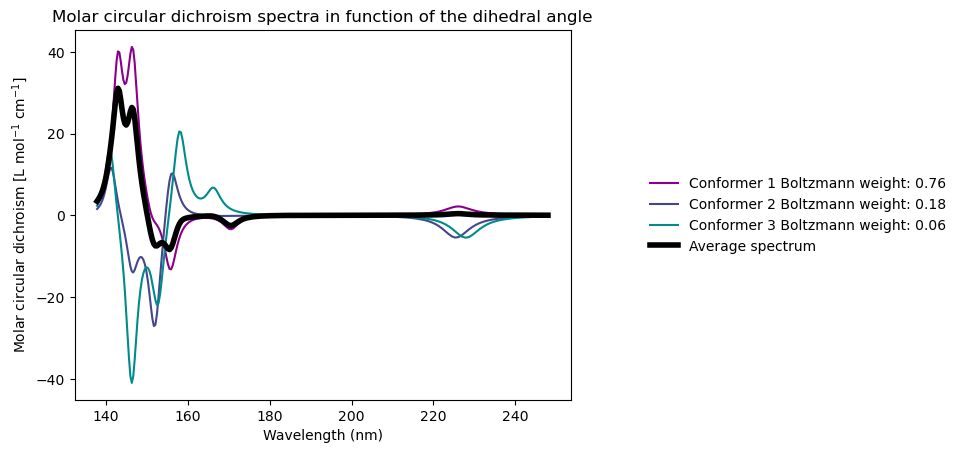

In [13]:
import matplotlib.pyplot as plt
x_data = np.linspace(5,9, 200)
x_data_nm = 1240 / x_data

fig, ax = plt.subplots()
colors = plt.cm.coolwarm(np.linspace(0, 1, len(rpa_results)))

colors = plt.cm.get_cmap('coolwarm', len(rpa_results))(np.linspace(0, 1, len(rpa_results)))
colors = [plt.cm.colors.to_rgba(c) for c in plt.cm.colors.LinearSegmentedColormap.from_list('custom', ['darkmagenta', 'darkcyan'])(np.linspace(0, 1, len(rpa_results)))]

for idx, (rpa_result, color) in enumerate(zip(rpa_results, colors)):
    spectra = rpa_solver.get_ecd_spectrum(rpa_result, x_data, x_unit='ev', b_unit='ev', b_value=0.1)
    ax.plot(x_data_nm, spectra['y_data'], color=color, label=f'Conformer {idx+1} Boltzmann weight: {weights[idx]:.2f}')

# plot an average spectrum of the conformers based on the boltzmann distribution
average_spectrum = np.zeros(len(x_data))
for weights, rpa_result in zip(weights, rpa_results):
    average_spectrum += weights * np.array(rpa_solver.get_ecd_spectrum(rpa_result, x_data, x_unit='ev', b_unit='ev', b_value=0.1)['y_data'])
ax.plot(x_data_nm, average_spectrum, color='black', linestyle='-', label='Average spectrum', linewidth=4)

plt.title('Molar circular dichroism spectra in function of the dihedral angle')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Molar circular dichroism [L mol$^{-1}$ cm$^{-1}$]')
plt.legend(frameon=False, borderaxespad=0., loc='center left', bbox_to_anchor=(1.15, 0.5))